<a href="https://colab.research.google.com/github/Blusooyeon/Dacon/blob/main/yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install ultralytics
%pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.6/599.6 kB 27.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import numpy as np
import cv2
import shutil
import yaml
import warnings
warnings.filterwarnings("ignore")

from ultralytics import YOLO
from glob import glob
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [ ]:
SEED = 42
BATCH_SIZE = 8
MODEL = "v8"
data_path = '/content/drive/MyDrive/detect_car'

In [ ]:
def make_yolo_dataset(image_paths, txt_paths, type="train"):
    for image_path, txt_path in tqdm(zip(image_paths, txt_paths if not type == "test" else image_paths), total=len(image_paths)):
        source_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image_height, image_width, _ = source_image.shape

        target_image_path = f"{data_path}/data/yolo_v8/{type}/{os.path.basename(image_path)}"
        cv2.imwrite(target_image_path, source_image)

        if type == "test":
            continue

        with open(txt_path, "r") as reader:
            yolo_labels = []
            for line in reader.readlines():
                line = list(map(float, line.strip().split(" ")))
                class_name = int(line[0])
                x_min, y_min = float(min(line[5], line[7])), float(min(line[6], line[8]))
                x_max, y_max = float(max(line[1], line[3])), float(max(line[2], line[4]))
                x, y = float(((x_min + x_max) / 2) / image_width), float(((y_min + y_max) / 2) / image_height)
                w, h = abs(x_max - x_min) / image_width, abs(y_max - y_min) / image_height
                yolo_labels.append(f"{class_name} {x} {y} {w} {h}")

        target_label_txt = f"{data_path}/data/yolo_v8/{type}/{os.path.basename(txt_path)}"
        with open(target_label_txt, "w") as writer:
            for yolo_label in yolo_labels:
                writer.write(f"{yolo_label}\n")

In [ ]:
image_paths = sorted(glob(data_path + "/data/train/*.png"))
txt_paths = sorted(glob(data_path + "/data/train/*.txt"))

train_images_paths, valid_images_paths, train_txt_paths, valid_txt_paths = train_test_split(image_paths, txt_paths, test_size=0.1, random_state=SEED)

make_yolo_dataset(train_images_paths, train_txt_paths, "train")
make_yolo_dataset(valid_images_paths, valid_txt_paths, "valid")
make_yolo_dataset(sorted(glob(data_path + "/data/test/*.png")), None, "test")

In [ ]:
with open(data_path + "/data/classes.txt", "r") as reader:
    lines = reader.readlines()
    classes = [line.strip().split(",")[1] for line in lines]

yaml_data = {
              "names": classes,
              "nc": len(classes),
              "path": "/content/drive/MyDrive/Colab Notebooks/ATL/합성데이터 기반 객체 탐지 AI 경진대회/data/yolo_v8/",
              "train": "train",
              "val": "valid",
              "test": "test"
            }

with open(data_path + "/data/yolocustom.yaml", "w") as writer:
    yaml.dump(yaml_data, writer)

with open(data_path + '/data/yolocustom.yaml', 'r') as writer:
    yolocustom_yaml = yaml.safe_load(writer)
    display(yolocustom_yaml)

In [ ]:
model = YOLO("yolov8x")
results = model.train(
    data="/content/drive/MyDrive/detect_car/data/yolo_v8/custom.yaml",
    imgsz= 640,
    epochs= 50,
    batch=BATCH_SIZE,
    patience=5,
    workers=16,
    device=0,
    exist_ok=True,
    project=f"{MODEL}",
    name="train",
    seed=SEED,
    pretrained=False,
    resume=False,
    optimizer="AdamW",
    lr0=5e-4,
    cos_lr=True,
    augment=False,
    val=True,
    mixup=0.3,
    mosaic=1.0,
    flipud=0.0,
    fliplr=0.0,
    scale=0.0,
    translate = 0.3
    )

100%|██████████| 131M/131M [00:07<00:00, 18.0MB/s]
Ultralytics YOLOv8.0.118 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/drive/MyDrive/detect_car/data/yolo_v8/custom.yaml, epochs=50, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=16, project=v8, name=train, exist_ok=True, pretrained=False, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

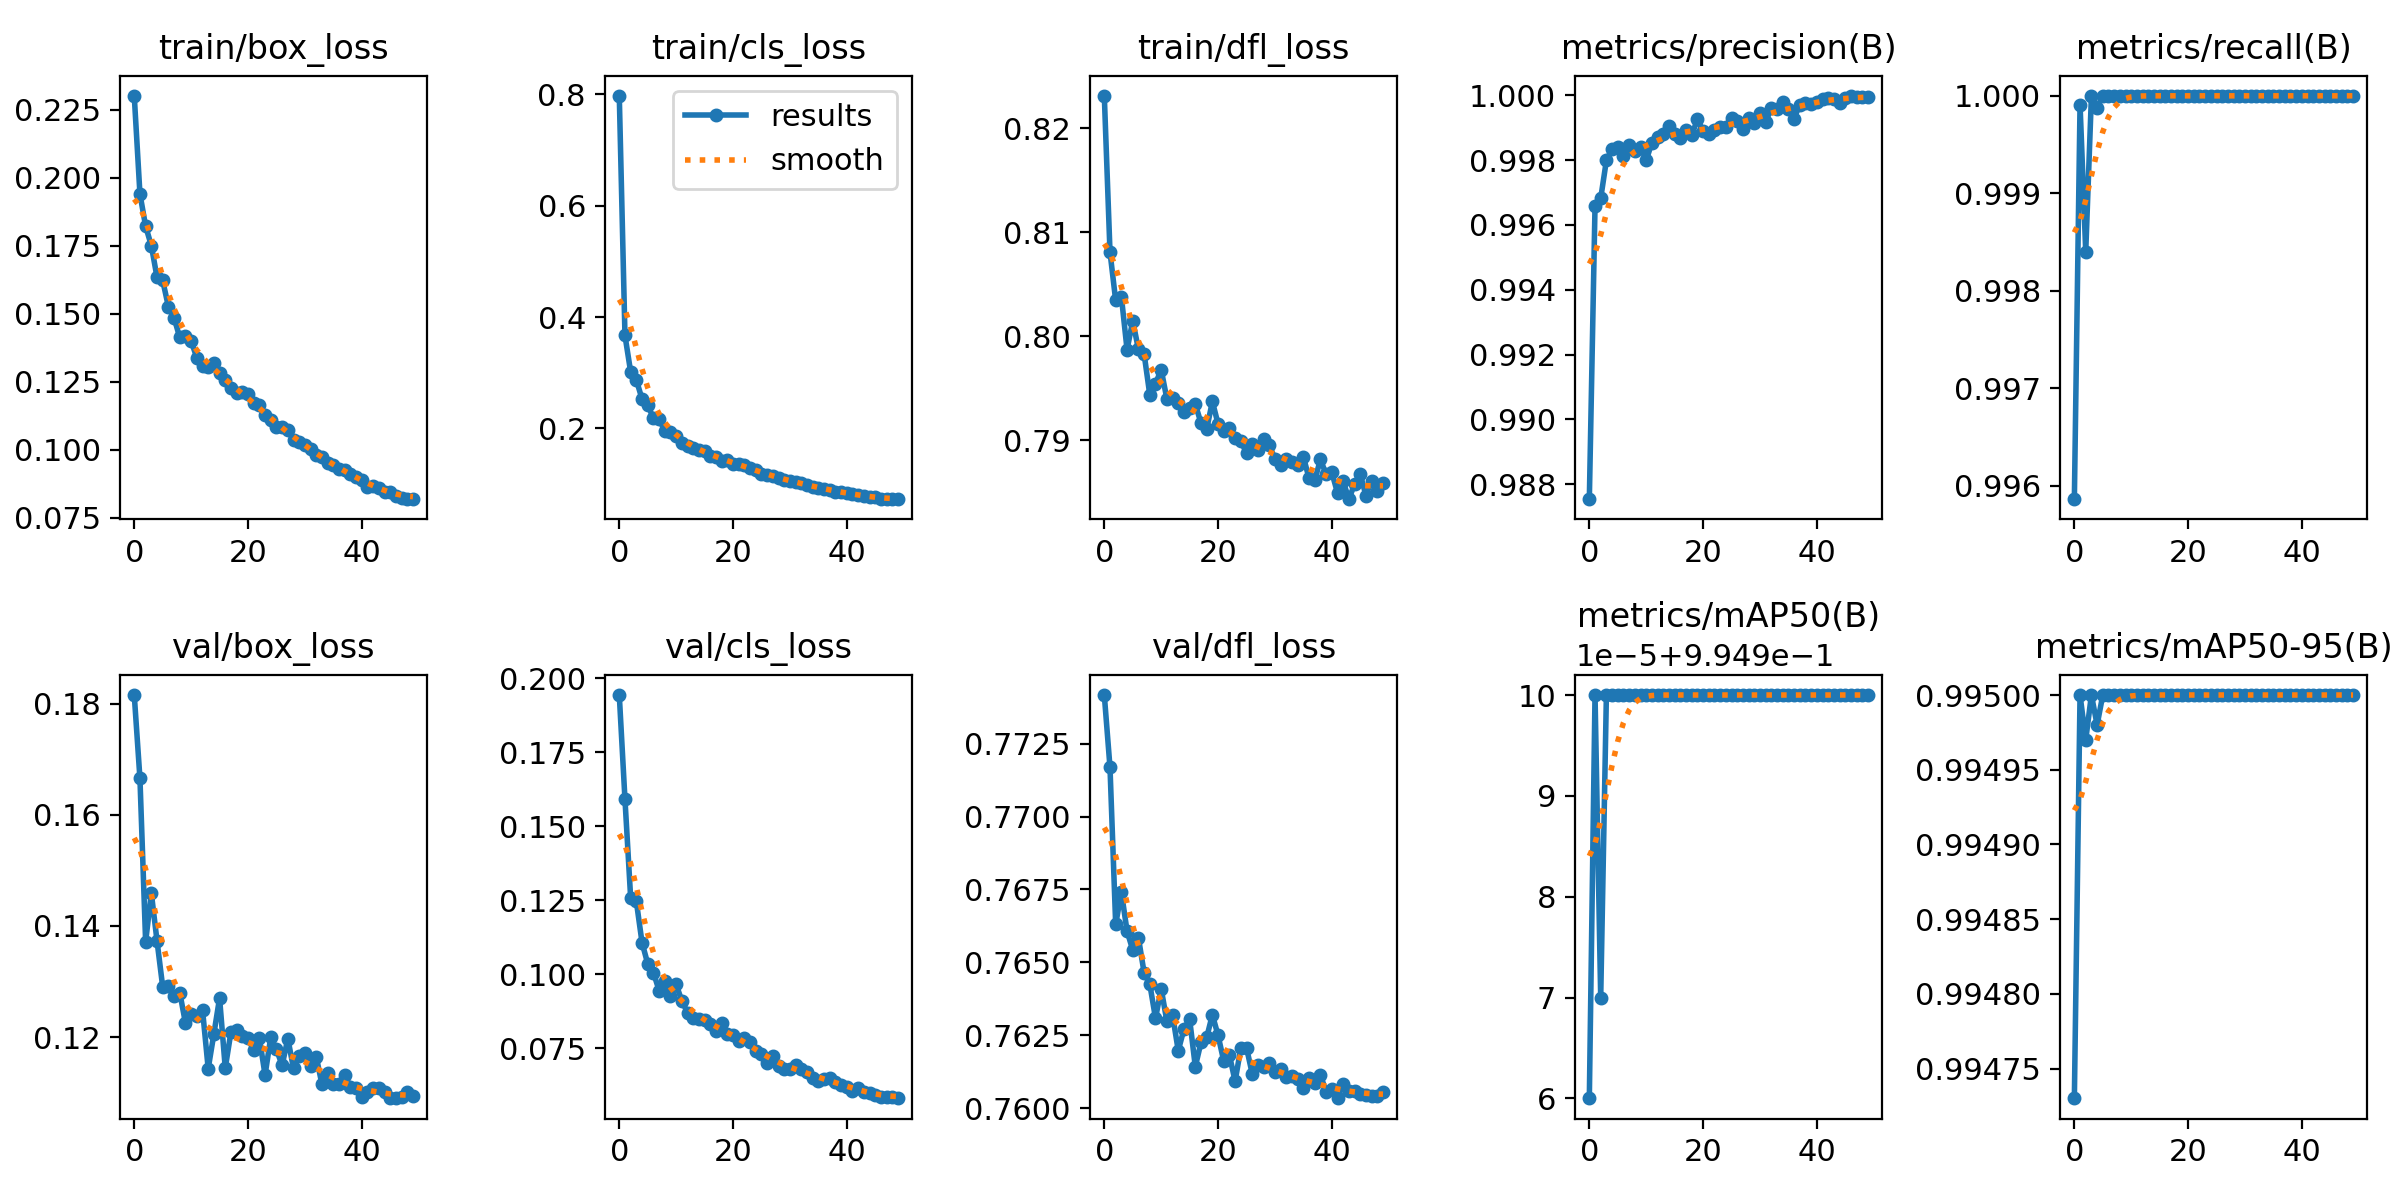

In [ ]:
from IPython.display import Image
Image(filename = '/content/v8/train/results.png',width = 1000)

In [ ]:
def get_test_image_paths(test_image_paths):
    for i in range(0, len(test_image_paths), BATCH_SIZE):
        yield test_image_paths[i:i+BATCH_SIZE]

In [ ]:
model = YOLO("/content/drive/MyDrive/detect_car/yolov8_1280/train/weights/best.pt")
test_image_paths = glob("/content/drive/MyDrive/detect_car/data/yolo_v8/test/*.png")
for i, image in tqdm(enumerate(get_test_image_paths(test_image_paths)), total=int(len(test_image_paths)/BATCH_SIZE)):
    model.predict(image, imgsz=(640, 640), iou=0.8, conf=0.3, save_conf=True, save=False, save_txt=True, project=f"{MODEL}", name="predict",
                  exist_ok=True, device=0, augment=True, verbose=False)
    if i % 5 == 0:
        clear_output(wait=True)

 99%|█████████▉| 421/425 [06:07<00:02,  1.37it/s]Results saved to v8/predict
1139 labels saved to v8/predict/labels
 99%|█████████▉| 422/425 [06:08<00:02,  1.38it/s]Results saved to v8/predict
1139 labels saved to v8/predict/labels
100%|█████████▉| 423/425 [06:09<00:01,  1.39it/s]Results saved to v8/predict
1139 labels saved to v8/predict/labels
100%|█████████▉| 424/425 [06:09<00:00,  1.38it/s]Results saved to v8/predict
1139 labels saved to v8/predict/labels
100%|██████████| 425/425 [06:10<00:00,  1.15it/s]


In [ ]:
def yolo_to_labelme(line, image_width, image_height, txt_file_name):
    file_name = txt_file_name.split("/")[-1].replace(".txt", ".png")
    class_id, x, y, width, height, confidence = [float(temp) for temp in line.split()]

    x_min = (x - width / 2) * image_width
    x_max = (x + width / 2) * image_width
    y_min = (y - height / 2) * image_height
    y_max = (y + height / 2) * image_height

    return file_name, int(class_id), confidence, x_min, y_min, x_max, y_min, x_max, y_max, x_min, y_max

In [ ]:
infer_txts = glob("/content/v8/predict/labels/*.txt")
results = []
for infer_txt in tqdm(infer_txts):
    base_file_name = infer_txt.split("/")[-1].split(".")[0]
    imgage_height, imgage_width = cv2.imread(f"/content/drive/MyDrive/detect_car/data/yolo_v8/test/{base_file_name}.png").shape[:2]
    with open(infer_txt, "r") as reader:
        lines = reader.readlines()
        for line in lines:
            results.append(yolo_to_labelme(line, imgage_width, imgage_height, infer_txt))

df_submission = pd.DataFrame(data=results, columns=["file_name", "class_id", "confidence", "point1_x", "point1_y", "point2_x", "point2_y", "point3_x", "point3_y", "point4_x", "point4_y"])
df_submission.to_csv(f"{data_path}/results/{MODEL}.csv", index=False)

100%|██████████| 1139/1139 [01:05<00:00, 17.43it/s]
